In [26]:
import h5py        
import copy
import os
import torch
import numpy as np
import pandas as pd
from torchdeepretina.analysis import compute_sta
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pyret.filtertools as ft
from torchdeepretina.utils import stack_filters
import torchdeepretina as tdr
from torchdeepretina.datas import loadexpt
import torch.nn as nn
import scipy.stats
import pickle


In [47]:
def RFDisplay(rf) :
  #Creates a display for a spatiotemporal receptive field (RF)
  #
  #space_ave,time_cen,time_sur = RFDisplay(RF)
  #
  #RF: Spatiotemporal receptive field (Time, X , Y)
  #space_ave: Spatial average of RF
  #time_cen: Time course of pixels in RF center
  #time_sur: Time course of pixels in RF surround
  #Center pixels are found by first taking the pixel with the largest
  #absolute value (peakval), then taking nearby pixels that
  #are some fraction of that max value
  #Surround pixels are found as pixels with the opposite sign
  #from the center, that are some fraction of the max surround pixel

  #Parameters: Threshold fractions of peakval to accept center and surround pixels
  cen_factor=0.5
  sur_factor=0.8
  cen_dist_factor=2
  sur_dist_factor=8

  #Preprocessing
  rftrunc=rf[2:40,:,:] # First two points sometimes have an outlier 

  ###Spatial average###
  space_ave=np.mean(rftrunc,axis=0)

  ###Center timecourse###

  #Find index [ctime,cx,cy] of peak value 
  rfabs=np.abs(rftrunc);
  [ctime,cx,cy]= np.unravel_index(np.argmax(rfabs, axis=None), rfabs.shape)
  spacepeak=rftrunc[ctime,:,:] #spatial slice at peak time
  peakval=rftrunc[ctime,cx,cy]

  #Identify center pixels as those greater than half of peakval
  #within twice the mean distance of those pixels from tne center
  large_idxs=np.argwhere(np.abs(peakval-spacepeak)<np.abs(peakval*cen_factor))
  dist=np.sqrt((large_idxs[:,0]-cx)**2+(large_idxs[:,1]-cy)**2)
  cen_x_indx=large_idxs[np.argwhere(dist<=cen_dist_factor*np.mean(dist)),0]
  cen_y_indx=large_idxs[np.argwhere(dist<=cen_dist_factor*np.mean(dist)),1]
  cen_idxs=np.concatenate((cen_x_indx,cen_y_indx),axis=1)
  #Add up the time courses from the center pixels
  time_cen=0
  rfnocenter=copy.deepcopy(rftrunc)
  for i in range (cen_idxs.shape[0]):
    time_cen=time_cen+rftrunc[:,cen_idxs[i,0],cen_idxs[i,1]];
    #remove the center pixels for later surround calculation
    rfnocenter[:,cen_idxs[i,0],cen_idxs[i,1]]=0 

  ###Surround timecourse###

  #Find surround pixels that have opposite sign from center
  if peakval>0 :
    [stime,sx,sy]= np.unravel_index(np.argmin(rfnocenter, axis=None), rfnocenter.shape)
  else :
    [stime,sx,sy]= np.unravel_index(np.argmax(rfnocenter, axis=None), rfnocenter.shape)
  negpeakval=rfnocenter[stime,sx,sy] #largest amplitude surround pixel

  #Identify surround pixels as those greater than half of peakval
  #within a factor of the mean distance of those pixels from tne center
  large_idxs=np.argwhere(np.abs(negpeakval-spacepeak)<np.abs(negpeakval*sur_factor))
  dist=np.sqrt((large_idxs[:,0]-cx)**2+(large_idxs[:,1]-cy)**2)
  sur_x_indx=large_idxs[np.argwhere(dist<=sur_dist_factor*np.mean(dist)),0]
  sur_y_indx=large_idxs[np.argwhere(dist<=sur_dist_factor*np.mean(dist)),1]
  sur_idxs=np.concatenate((sur_x_indx,sur_y_indx),axis=1)
   #Add up the time courses from the surround pixels
  time_sur=0
  for i in range (sur_idxs.shape[0]):
    time_sur=time_sur+rftrunc[:,sur_idxs[i,0],sur_idxs[i,1]]
  print(time_cen)
  #Scale center and surround timecourses to a max amplitude of one
  #time_cen=(time_cen-time_cen.mean())/np.max(abs(time_cen))
  #time_sur=(time_sur-time_sur.mean())/np.max(abs(time_sur))
  time_cen=time_cen/(np.max(abs(time_cen) + 1e-8 ))
  time_sur=time_sur/np.max(abs(time_sur))
  space_ave=space_ave[16:35,16:35]

  return spacepeak,time_cen,time_sur




In [48]:
# Pickle files are made using 
# pickle_folders = ["relu_pickles","conv_pickles", "bnorm_pickles", "pickles_dup"]
pickle_folders = ["../relu_pickles"]
pickle_paths = []
for pickle_folder in pickle_folders:
    paths = sorted(os.listdir(pickle_folder))
    for p in paths:
        if ".p" == p[-2:]:
            pickle_paths.append(os.path.join(pickle_folder, p))
for i,path in enumerate(pickle_paths):
        print(i,path)

0 ../relu_pickles/convgc_naturalscene15-10-07_1582749400_revcorFalse_nsamp5000_ctrst0.35_stas.p


In [49]:
idxs = [0]

File: ../relu_pickles/convgc_naturalscene15-10-07_1582749400_revcorFalse_nsamp5000_ctrst0.35_stas.p
dict_keys(['sequential.3', 'sequential.7'])
[-0.06237867 -0.07040872 -0.06734289 -0.07519878 -0.07940795 -0.05836495
 -0.05940521 -0.07720915 -0.07182816 -0.04740939 -0.0337459  -0.03319725
 -0.0274709  -0.03252365 -0.01577866  0.01661711  0.06331732  0.09619237
  0.137427    0.13774183  0.14795378  0.14415324  0.13019338  0.11739026
  0.10650261  0.09073254  0.0484053   0.01112576  0.01760603  0.02425665
  0.02895887  0.02261912  0.03682917  0.02456972  0.00540983 -0.00108942
 -0.0058208  -0.00901193]
[ 0.04196991  0.04744548  0.0459587   0.05303366  0.05332768  0.03502002
  0.03486967  0.04747609  0.04372386  0.02725364  0.01656535  0.01432836
  0.00691377  0.00332833 -0.00969746 -0.03887368 -0.08401569 -0.10886812
 -0.13870238 -0.13594167 -0.13374895 -0.11635246 -0.08587419 -0.05727521
 -0.03289459 -0.01417159  0.02124028  0.0422947   0.02470127  0.01047492
 -0.00252676 -0.00654694 -0

TypeError: object of type 'numpy.float64' has no len()

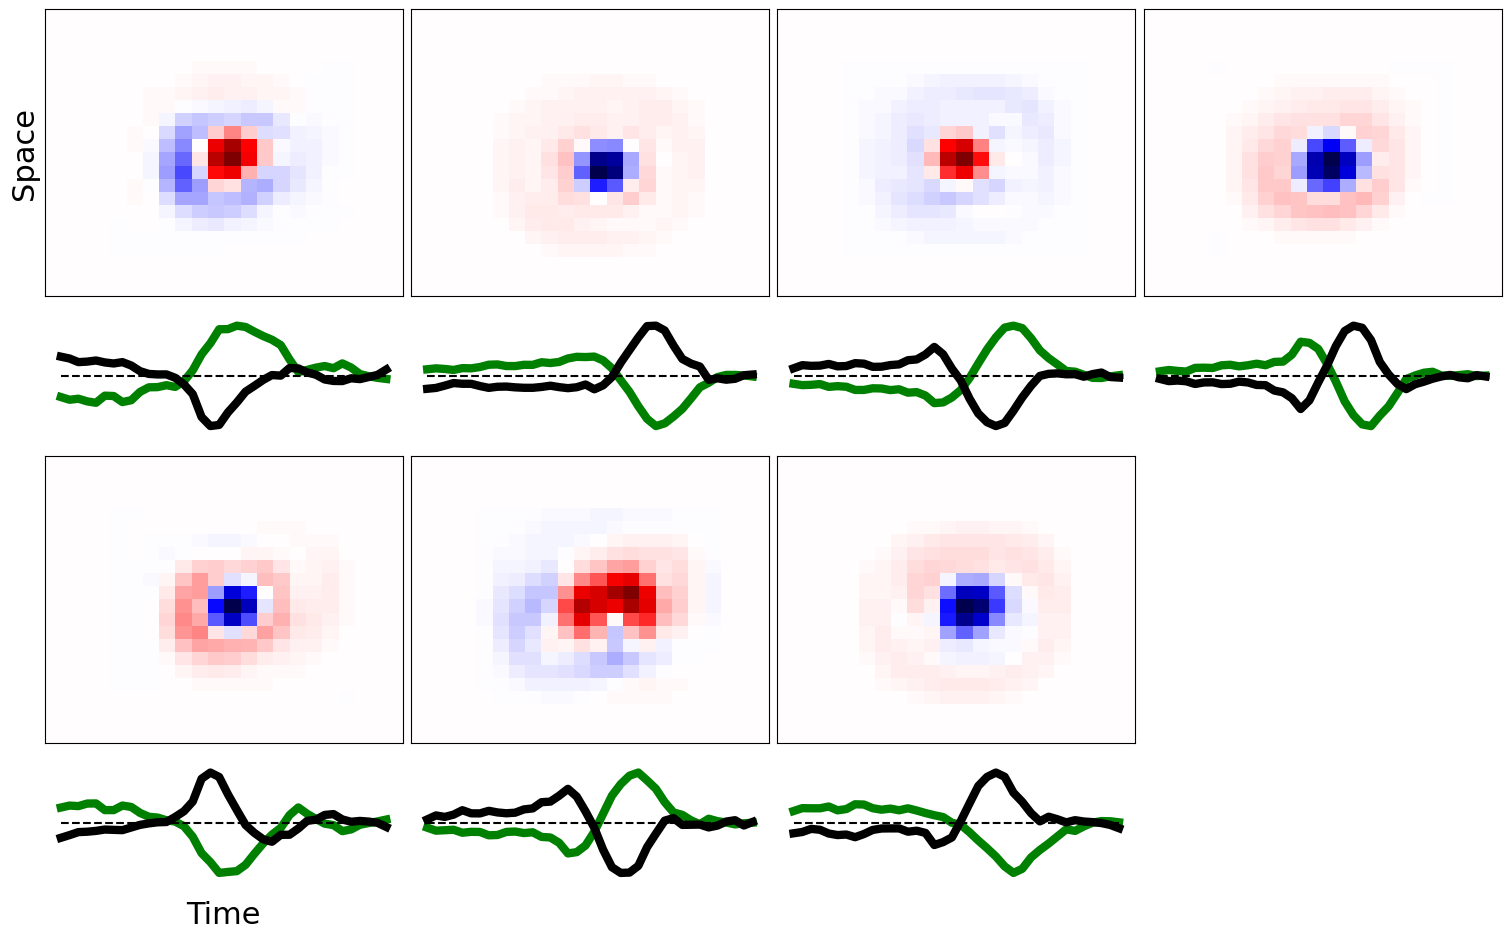

In [50]:
for idx in idxs:
    path = pickle_paths[idx]
    sta_save_file = path
    if os.path.exists(sta_save_file):
        with open(sta_save_file, 'rb') as f:
            init_dict = pickle.load(f)
    else:
        print("File Does not Exist")
    sta_dict = dict()
    for layer in init_dict.keys():
        sta_dict[layer] = []
        try:
            for chan,sta in enumerate(init_dict[layer]["stas"]):
                sta_dict[layer].append(sta)
        except:
            print(init_dict[layer].keys())
            try:
                for chan,sta in enumerate(init_dict[layer]):
                    sta_dict[layer].append(init_dict[layer][sta])
            except:
                for chan,sta in enumerate(init_dict[layer]):
                    sta_dict[layer].append(init_dict[layer]["spatials"][sta])
                 
    print("File:", path)
    print(sta_dict.keys())
    
    subt = 2
    layers = sorted(list(sta_dict.keys()))
    for l,layer in enumerate(layers):
        fig = plt.figure(figsize=(15,10),constrained_layout=True)
        size = (13,4)
        span = int(size[0]//2)
        #hspace=0.05,wspace=0.5,,left=0.02, right=0.95
        gridspec.GridSpec(*size)
        for i in range(len(sta_dict[layer])):
            rf = np.asarray(sta_dict[layer][i])
            spatial,temporal,temporal_sur = RFDisplay(rf)
            scaler = .35
            temporal = temporal*scaler
            temporal_sur = temporal_sur*scaler
            absmax = np.abs(spatial).max()
        
        
            loc = (1+(i%2)*span+(span-subt),i//2)
            ax = plt.subplot2grid(size,loc, rowspan=subt)    
            plt.rcParams.update({'font.size': 22})
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_yticks([])
            ax.set_xticks([])
            ax.set_ylim([-.5,.5])
        #     ax.set_aspect(aspect=20)
            plt.box(on=None)
            linewidth = 6
            tstart = 0
            tend = len(temporal)
            plt.plot(temporal[tstart:tend], "g", linewidth=linewidth)
            try:
                plt.plot(temporal_sur[tstart:tend],'k',linewidth=linewidth)
            except:
                print(temporal_sur)
            plt.plot(np.zeros(len(temporal[tstart:tend])),'k--')
            if i == 1:
                ax = plt.gca()
                ax.set_xlabel("Time")
            
            ax = plt.subplot2grid(size,(1+(i%2)*span,i//2),rowspan=int(span-subt))
        #     plt.rcParams.update({'font.size': 10})
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_yticks([])
            ax.set_xticks([])
            im = plt.imshow(spatial[14:36,14:36], cmap = 'seismic', vmin=-absmax, vmax=absmax, aspect="auto")
            if i==0:
                ax.set_ylabel("Space")
            #plt.colorbar(im,fraction=0.046, pad=0.04)
        plt.suptitle("Layer {} Receptive Fields".format(l+1))
        plt.savefig("interneuron_rfs_layer{}.pdf".format(layer), bbox_inches="tight")
        plt.show()


## Interneurons

In [ ]:
pickles = os.listdir("pickles")
ps = []
for p in pickles:
    if "intrnrn" in p:
        ps.append(p)

In [ ]:
spatials = []
temporals = []
stas = []
for p in ps:
    path = os.path.join("pickles/", p)
    if os.path.exists(sta_save_file):
        with open(path, 'rb') as f:
            sta_dict = pickle.load(f)
            spatials.append(sta_dict['outputs']['spatials'])
            temporals.append(sta_dict['outputs']['temporals'])
            stas.append(sta_dict['outputs']['stas'][0])
    else:
        print("File Does not Exist")

In [ ]:
len(stas)

In [ ]:
spatials = []
temporals = []
temporal_surs = []
layer = sorted(list(layers))[0]
for rf in stas:
    space_ave,time_cen,time_sur = RFDisplay(rf)
    spatials.append(space_ave)
    temporals.append(time_cen)
    temporal_surs.append(time_sur)

fig = plt.figure(figsize=(31,30),constrained_layout=True)
cols, rows = (8,6) #(cols, rows)
size = (3*cols+1,2*rows)
span = int(size[0]//rows)
#hspace=0.05,wspace=0.5,,left=0.02, right=0.95
gridspec.GridSpec(*size)

# spat_mult = [1, -1, -1, 1, 1, -1, -1, -1]
spat_mult = np.ones(len(spatials))
# temp_mult = [1, 1, 1, 1, 1, -1, 1, 1]
temp_mult = np.ones(len(spatials))
subt = 2
for i in range(len(stas)):
    spatial, temporal = spatials[i]*spat_mult[i], temporals[i]*temp_mult[i]
    temporal_sur = temporal_surs[i]
    scaler = .3
    temporal = temporal*scaler
    temporal_sur = temporal_sur*scaler
    absmax = np.abs(spatial).max()
#     spatial = spatial[14:37,10:34]
    
#     plt.suptitle("Layer 1 Receptive Fields")
    loc = (1+(i%rows)*span+(span-subt),i//rows)
    ax = plt.subplot2grid(size,loc, rowspan=subt)    
    plt.rcParams.update({'font.size': 22})
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim([-.5,.5])
#     ax.set_aspect(aspect=20)
    plt.box(on=None)
    plt.plot(temporal[2:], "k", linewidth=7)
    if isinstance(temporal_sur, np.ndarray):
        plt.plot(temporal_sur[2:],'b',linewidth=6)
    plt.plot(np.zeros(len(temporal[2:])),'k--')
    if i == 1:
        ax = plt.gca()
        ax.set_xlabel("Time")
    
    ax = plt.subplot2grid(size,(1+(i%rows)*span,i//rows),rowspan=int(span-subt))
#     plt.rcParams.update({'font.size': 10})
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    shape = spatial.shape
    argmax = np.argmax(np.abs(spatial.ravel()))
    row,col = np.unravel_index(argmax, shape)
    win_size = 22//2
    low_row = max(0,row-win_size)
    high_row = min(shape[-2],row+win_size)
    low_col = max(0,col-win_size)
    high_col = min(shape[-1],col+win_size)
    if (high_row - low_row) < win_size*2:                      
        if high_row < 2*win_size: high_row = 2*win_size            
        if low_row > 2*win_size: low_row = max_row-2*win_size   
        print("high_row:", high_row)                       
        print("low_row:", low_row)                         
    if (high_col - low_col) < win_size*2:                      
        if high_col < 2*win_size: high_col = 2*win_size            
        if low_col > 2*win_size: low_col = max_col-2*win_size   
        print("high_col:", high_col)                       
        print("low_col:", low_col)                         
    im = plt.imshow(spatial[low_row:high_row, low_col:high_col], cmap = 'seismic', vmin=-absmax, vmax=absmax, aspect="auto")
    if i==0:
        ax.set_ylabel("Space")
    #plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

### From the data

In [47]:
stims, mems, _ = tdr.datas.load_interneuron_data()

In [48]:
stims.keys()

dict_keys(['unks_17-10-18.h5', 'amacrines_early_2012.h5', 'bipolars_early_2012.h5', 'bipolars_late_2012.h5', 'amacrines_late_2012.h5'])

In [51]:
k = list(stims.keys())[0]
stims[k]['boxes'].shape

(27400, 32, 32)

In [53]:
mems[k]['boxes'].shape

(14, 27360)

In [62]:
cors = []
for k in stims.keys():
    stim = stims[k]['boxes']
    stim = tdr.stimuli.rolling_window(stim,40)
    shape = stim.shape[1:]
    stim = stim.reshape(len(stim),-1)
    mem = mems[k]['boxes'].T
    cor = tdr.utils.mtx_cor(mem,stim,to_numpy=True)
    cor = cor.reshape(-1,*shape)
    cors.append(cor)

In [63]:
for cor in cors:
    print(cor.shape)

(14, 40, 32, 32)
(5, 40, 38, 38)
(3, 40, 38, 38)
(4, 40, 38, 38)
(22, 40, 38, 38)


In [64]:
stas = []
for cor in cors:
    for c in cor:
        stas.append(c)

high_row: 22
low_row: 0


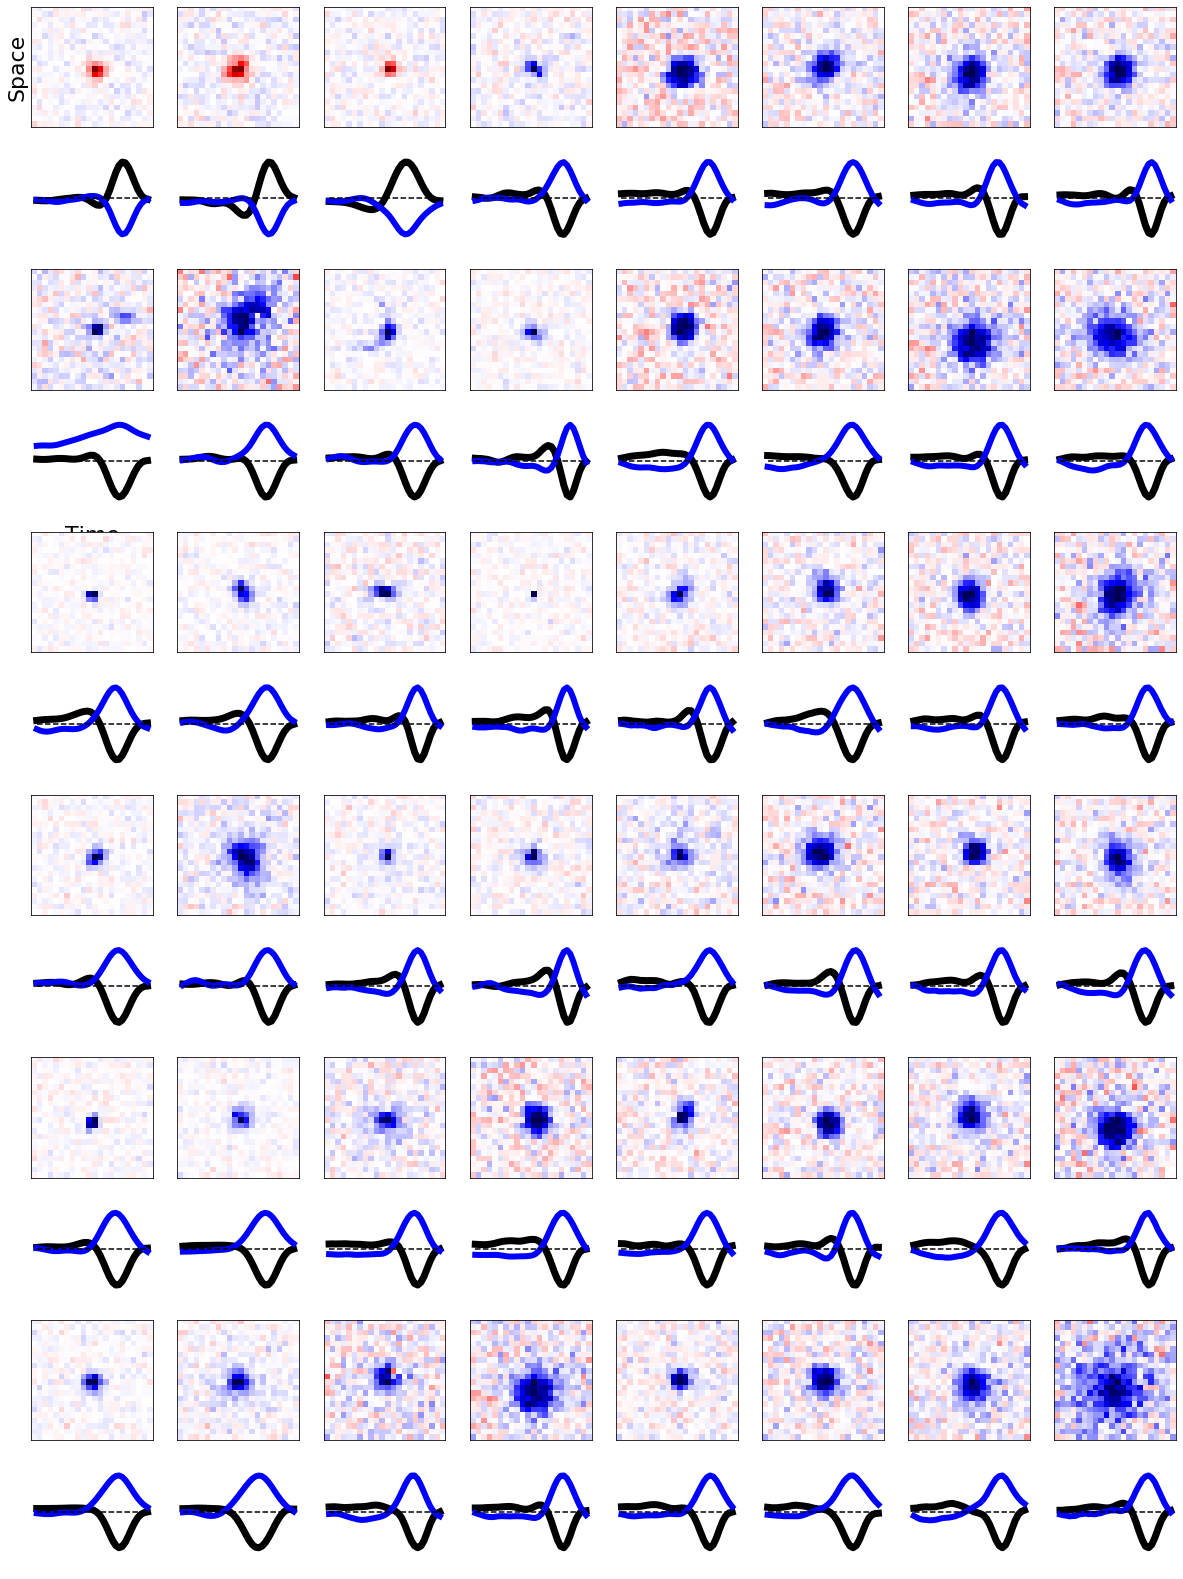

In [65]:
spatials = []
temporals = []
temporal_surs = []
layer = sorted(list(layers))[0]
for rf in stas:
    space_ave,time_cen,time_sur = RFDisplay(rf)
    spatials.append(space_ave)
    temporals.append(time_cen)
    temporal_surs.append(time_sur)

fig = plt.figure(figsize=(31,30),constrained_layout=True)
cols, rows = (8,6) #(cols, rows)
size = (3*cols+1,2*rows)
span = int(size[0]//rows)
#hspace=0.05,wspace=0.5,,left=0.02, right=0.95
gridspec.GridSpec(*size)

# spat_mult = [1, -1, -1, 1, 1, -1, -1, -1]
spat_mult = np.ones(len(spatials))
# temp_mult = [1, 1, 1, 1, 1, -1, 1, 1]
temp_mult = np.ones(len(spatials))
subt = 2
for i in range(len(stas)):
    spatial, temporal = spatials[i]*spat_mult[i], temporals[i]*temp_mult[i]
    temporal_sur = temporal_surs[i]
    scaler = .3
    temporal = temporal*scaler
    temporal_sur = temporal_sur*scaler
    absmax = np.abs(spatial).max()
#     spatial = spatial[14:37,10:34]
    
#     plt.suptitle("Layer 1 Receptive Fields")
    loc = (1+(i%rows)*span+(span-subt),i//rows)
    ax = plt.subplot2grid(size,loc, rowspan=subt)    
    plt.rcParams.update({'font.size': 22})
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim([-.5,.5])
#     ax.set_aspect(aspect=20)
    plt.box(on=None)
    plt.plot(temporal[2:], "k", linewidth=7)
    if isinstance(temporal_sur, np.ndarray):
        plt.plot(temporal_sur[2:],'b',linewidth=6)
    plt.plot(np.zeros(len(temporal[2:])),'k--')
    if i == 1:
        ax = plt.gca()
        ax.set_xlabel("Time")
    
    ax = plt.subplot2grid(size,(1+(i%rows)*span,i//rows),rowspan=int(span-subt))
#     plt.rcParams.update({'font.size': 10})
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    shape = spatial.shape
    argmax = np.argmax(np.abs(spatial.ravel()))
    row,col = np.unravel_index(argmax, shape)
    win_size = 22//2
    low_row = max(0,row-win_size)
    high_row = min(shape[-2],row+win_size)
    low_col = max(0,col-win_size)
    high_col = min(shape[-1],col+win_size)
    if (high_row - low_row) < win_size*2:                      
        if high_row < 2*win_size: high_row = 2*win_size            
        if low_row > 2*win_size: low_row = max_row-2*win_size   
        print("high_row:", high_row)                       
        print("low_row:", low_row)                         
    if (high_col - low_col) < win_size*2:                      
        if high_col < 2*win_size: high_col = 2*win_size            
        if low_col > 2*win_size: low_col = max_col-2*win_size   
        print("high_col:", high_col)                       
        print("low_col:", low_col)                         
    im = plt.imshow(spatial[low_row:high_row, low_col:high_col], cmap = 'seismic', vmin=-absmax, vmax=absmax, aspect="auto")
    if i==0:
        ax.set_ylabel("Space")
    #plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()